In [1]:
# Data manipulation
from os import path
import numpy as np
import pandas as pd
from itertools import groupby
import os
import csv
import math

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.colors import ListedColormap
import seaborn as sns

# Images manipulation
from skimage import img_as_float, img_as_ubyte, exposure, feature, morphology, measure, segmentation, transform, color
from skimage.restoration import denoise_nl_means, unsupervised_wiener, denoise_tv_bregman, denoise_bilateral
from skimage.util import compare_images, invert
from skimage.filters import threshold_multiotsu, difference_of_gaussians
#from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.registration import phase_cross_correlation
from skimage.io import imread
from scipy import stats, misc, ndimage
import cv2
import pyclesperanto_prototype as cle

# Network analysis
#import porespy as ps
#import openpnm as op
#import pytrax as pt

# Custom Color map with black as first color
cmap = plt.cm.get_cmap('terrain', 256)
newcolors = cmap(np.random.randint(256, size=100))
dark = np.array([0/256, 0/256, 0/256, 1])
newcolors[:1, :] = dark
custom_cmap = ListedColormap(newcolors)

matplotlib.rcParams['figure.figsize'] = (10, 10)

In [2]:
# Parameters 

# Reading the input file

# Image path and name
Inputs = pd.read_excel (r'Inputs_powder_PSD.xlsx')

folder_name = (Inputs["Parameters' value"][1])
print("Results path = ", folder_name)

#path_original = folder_name + "\\" + file_name

# Scaledar detection
backgound_clr = str(Inputs["Parameters' value"][3]) # This stands for the color of the background - possible values: "b" for black, "w" for white, and "g" for grey
print("Background color = ", backgound_clr)

scalebar_clr = str(Inputs["Parameters' value"][4]) # This stands for the color of the scalebar - possible values: "b" for black, "w" for white, and "g" for grey
print("Scalebar color = ", scalebar_clr)

scalebar_lenght = float(Inputs["Parameters' value"][5]) # Scalebar size in um
print("Scalebar lenght (um) = ", scalebar_lenght) # Problem, it would require having only images at the ssame magnification (alternatively, file for each giving the roultion and we read them)

# Voronoi-based istance segmentation
sigma_voronoi_center = (Inputs["Parameters' value"][7]) # Gaussian filter sigma (higher than sigma_dividing) to find the center of the voronois
try:
    sigma_voronoi_center = int(sigma_voronoi_center)
except:
    sigma_voronoi_center = 6
print("Gaussian for Voronois' center = ", sigma_voronoi_center)

sigma_dividing = (Inputs["Parameters' value"][8]) # Gaussian filter sigma (higher than sigma_dividing) to find the center of the voronois
try:
    sigma_dividing = int(sigma_dividing)
except:
    sigma_dividing = 1
print("Gaussian for Voronois' separation = ", sigma_dividing)

border_0 = str(Inputs["Parameters' value"][9]) # If removing (True) or not (False) particles touching the borders (advised: True)
if border_0 == "No":
    border = False
else:
    border = True
print("Removing particles on borders = ", border)

limit_shape = (Inputs["Parameters' value"][10]) # Minimum acceptable 2*area/(perimenter*effective_radius) for the identified paraticles
try:
    limit_shape = float(limit_shape)
except:
    limit_shape = 0
print("Ratio to remove elongated particles = ", limit_shape)

limit_size = (Inputs["Parameters' value"][11]) # Minimum acceptable particle size
try:
    limit_size = float(limit_size)
except:
    limit_size = 0
print("Minimum acceptable particle size (um) = ", limit_size)

# Mateials density 
density_g_cm3 = (Inputs["Parameters' value"][13]) # Powder density in g/cm3 - to estimate the specific area distribution
try:
    density_g_cm3 = float(density_g_cm3)
except:
    density_g_cm3 = 0
print("Powder density [g cm-3] = ", density_g_cm3)

Results path =  C:\Users\teolo\Documents\Teo\Codes\New\SEM-segmentation and particle reconition\Final_2023_01\Powder PSD analysis - 2D\Version 2\Example problem\Evaluation\Test_23_05_10\Test single particles
Background color =  w
Scalebar color =  b
Scalebar lenght (um) =  10.0
Gaussian for Voronois' center =  6
Gaussian for Voronois' separation =  2
Removing particles on borders =  True
Ratio to remove elongated particles =  nan
Minimum acceptable particle size (um) =  nan
Powder density [g cm-3] =  4.0


In [3]:
def scalebar_detection(img, color_bkg=backgound_clr, color_bar=scalebar_clr, fib='False'):

    if color_bkg == 'b':
        thres = 0
    elif color_bkg == 'w':
        thres = 255
    elif color_bkg == 'g':
        thres = 96
    
    # Threshold values for the scalebar 
    if color_bar == 'w':
        thres_bar = 200
    elif color_bar == 'b':
        thres_bar = 20
    
    if fib:
        tick_l = 35
    else:
        tick_l = 25

    # Check the mode-color for each line, this detects at wich pixel the HUD is reached
    for line in range(len(img)):
        mode = stats.mode(img[line])
        if line >= 1:
            if int(mode[0]) == thres:
                boundary_h = line
                break
    
    # Separates the HUD from the rest of the image
    ime = img[boundary_h: , : ]

    # Vertical bar detection, for each line the number of contigous pixel
    # of the specified color are counted. This assumes that only the scalebar
    # is characterized by 'long' vertical lines of the given color
    boundary_v = []
    for i in range(1,ime.shape[1]-4):
        if color_bar == 'w':
            for key, group in groupby(ime[:,i]>thres_bar):
                if key:
                    a_list = np.array(list(group))
                    if len(a_list)> tick_l and a_list.all():
                        if (i-1) not in boundary_v:
                            boundary_v.append(i)
                    if len(boundary_v) >= 2:
                        break
        elif color_bar == 'b':
            for key, group in groupby(ime[:,i]<thres_bar):
                if key:
                    a_list = np.array(list(group))
                    if len(a_list)> tick_l and a_list.all():
                        if (i-1) not in boundary_v:
                            boundary_v.append(i)
                    if len(boundary_v) >= 2:
                        break
    return boundary_h, boundary_v

02_00.tif
Scalebar detectected. Pixel resolution =  208.33333333333334
Denoise done


C:\Users\teolo\AppData\Local\Temp\ipykernel_268\781834158.py:68: FutureWarning: `multichannel` is a deprecated argument name for `denoise_nl_means`. It will be removed in version 1.0. Please use `channel_axis` instead.
  NLM_denoised = denoise_nl_means(original_img, h=0.04, fast_mode=True, patch_size=5, patch_distance=6, multichannel=False, preserve_range=False)


Histogram equalization done


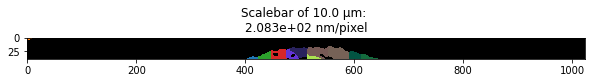

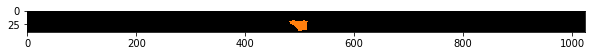

Total objects detected:  1.0


C:\Users\teolo\AppData\Local\Programs\Python\Python310\lib\site-packages\pyclesperanto_prototype\_tier9\_imshow.py:46: UserWarning: The imshow parameter color_map is deprecated. Use colormap instead.
  warnings.warn("The imshow parameter color_map is deprecated. Use colormap instead.")


Paticles identification done
Index(['label', 'original_label', 'bbox_min_x', 'bbox_min_y', 'bbox_min_z',
       'bbox_max_x', 'bbox_max_y', 'bbox_max_z', 'bbox_width', 'bbox_height',
       'bbox_depth', 'min_intensity', 'max_intensity', 'sum_intensity', 'area',
       'mean_intensity', 'sum_intensity_times_x', 'mass_center_x',
       'sum_intensity_times_y', 'mass_center_y', 'sum_intensity_times_z',
       'mass_center_z', 'sum_x', 'centroid_x', 'sum_y', 'centroid_y', 'sum_z',
       'centroid_z', 'sum_distance_to_centroid', 'mean_distance_to_centroid',
       'sum_distance_to_mass_center', 'mean_distance_to_mass_center',
       'standard_deviation_intensity', 'max_distance_to_centroid',
       'max_distance_to_mass_center', 'mean_max_distance_to_centroid_ratio',
       'mean_max_distance_to_mass_center_ratio', 'perimeter'],
      dtype='object')


C:\Users\teolo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
C:\Users\teolo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
C:\Users\teolo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


Paticles properties determination and plotting done done

02_01.tif
Scalebar detectected. Pixel resolution =  222.22222222222223


C:\Users\teolo\AppData\Local\Temp\ipykernel_268\781834158.py:68: FutureWarning: `multichannel` is a deprecated argument name for `denoise_nl_means`. It will be removed in version 1.0. Please use `channel_axis` instead.
  NLM_denoised = denoise_nl_means(original_img, h=0.04, fast_mode=True, patch_size=5, patch_distance=6, multichannel=False, preserve_range=False)


Denoise done
Histogram equalization done


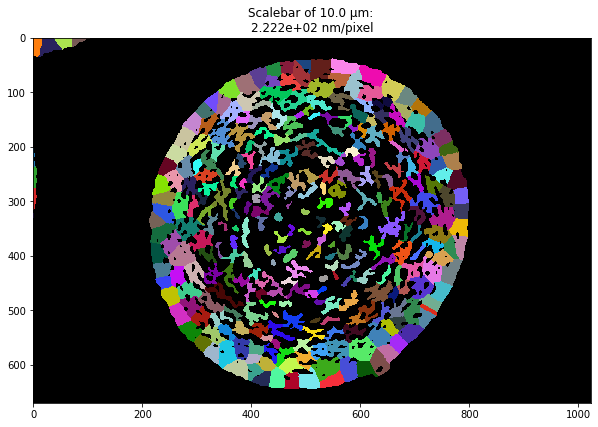

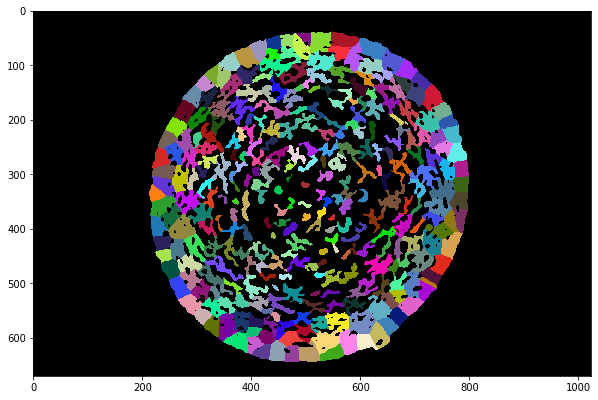

Total objects detected:  303.0


C:\Users\teolo\AppData\Local\Programs\Python\Python310\lib\site-packages\pyclesperanto_prototype\_tier9\_imshow.py:46: UserWarning: The imshow parameter color_map is deprecated. Use colormap instead.
  warnings.warn("The imshow parameter color_map is deprecated. Use colormap instead.")


Paticles identification done
Index(['label', 'original_label', 'bbox_min_x', 'bbox_min_y', 'bbox_min_z',
       'bbox_max_x', 'bbox_max_y', 'bbox_max_z', 'bbox_width', 'bbox_height',
       'bbox_depth', 'min_intensity', 'max_intensity', 'sum_intensity', 'area',
       'mean_intensity', 'sum_intensity_times_x', 'mass_center_x',
       'sum_intensity_times_y', 'mass_center_y', 'sum_intensity_times_z',
       'mass_center_z', 'sum_x', 'centroid_x', 'sum_y', 'centroid_y', 'sum_z',
       'centroid_z', 'sum_distance_to_centroid', 'mean_distance_to_centroid',
       'sum_distance_to_mass_center', 'mean_distance_to_mass_center',
       'standard_deviation_intensity', 'max_distance_to_centroid',
       'max_distance_to_mass_center', 'mean_max_distance_to_centroid_ratio',
       'mean_max_distance_to_mass_center_ratio', 'perimeter'],
      dtype='object')
Paticles properties determination and plotting done done

02_02.tif
Scalebar detectected. Pixel resolution =  5000.0


C:\Users\teolo\AppData\Local\Temp\ipykernel_268\781834158.py:68: FutureWarning: `multichannel` is a deprecated argument name for `denoise_nl_means`. It will be removed in version 1.0. Please use `channel_axis` instead.
  NLM_denoised = denoise_nl_means(original_img, h=0.04, fast_mode=True, patch_size=5, patch_distance=6, multichannel=False, preserve_range=False)


Denoise done
Histogram equalization done


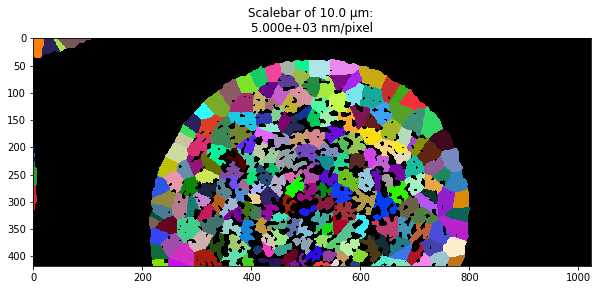

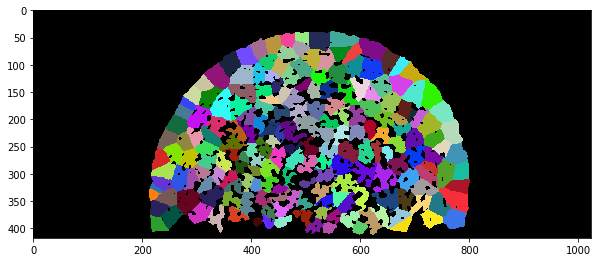

Total objects detected:  199.0


C:\Users\teolo\AppData\Local\Programs\Python\Python310\lib\site-packages\pyclesperanto_prototype\_tier9\_imshow.py:46: UserWarning: The imshow parameter color_map is deprecated. Use colormap instead.
  warnings.warn("The imshow parameter color_map is deprecated. Use colormap instead.")


Paticles identification done
Index(['label', 'original_label', 'bbox_min_x', 'bbox_min_y', 'bbox_min_z',
       'bbox_max_x', 'bbox_max_y', 'bbox_max_z', 'bbox_width', 'bbox_height',
       'bbox_depth', 'min_intensity', 'max_intensity', 'sum_intensity', 'area',
       'mean_intensity', 'sum_intensity_times_x', 'mass_center_x',
       'sum_intensity_times_y', 'mass_center_y', 'sum_intensity_times_z',
       'mass_center_z', 'sum_x', 'centroid_x', 'sum_y', 'centroid_y', 'sum_z',
       'centroid_z', 'sum_distance_to_centroid', 'mean_distance_to_centroid',
       'sum_distance_to_mass_center', 'mean_distance_to_mass_center',
       'standard_deviation_intensity', 'max_distance_to_centroid',
       'max_distance_to_mass_center', 'mean_max_distance_to_centroid_ratio',
       'mean_max_distance_to_mass_center_ratio', 'perimeter'],
      dtype='object')
Paticles properties determination and plotting done done

02_03.tif
Scalebar detectected. Pixel resolution =  222.22222222222223


C:\Users\teolo\AppData\Local\Temp\ipykernel_268\781834158.py:68: FutureWarning: `multichannel` is a deprecated argument name for `denoise_nl_means`. It will be removed in version 1.0. Please use `channel_axis` instead.
  NLM_denoised = denoise_nl_means(original_img, h=0.04, fast_mode=True, patch_size=5, patch_distance=6, multichannel=False, preserve_range=False)


Denoise done
Histogram equalization done


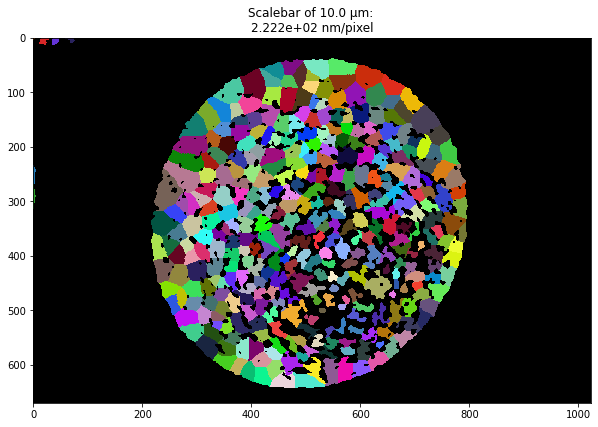

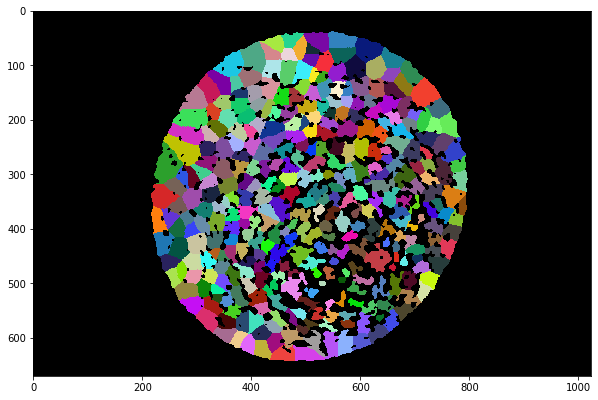

Total objects detected:  347.0


C:\Users\teolo\AppData\Local\Programs\Python\Python310\lib\site-packages\pyclesperanto_prototype\_tier9\_imshow.py:46: UserWarning: The imshow parameter color_map is deprecated. Use colormap instead.
  warnings.warn("The imshow parameter color_map is deprecated. Use colormap instead.")


Paticles identification done
Index(['label', 'original_label', 'bbox_min_x', 'bbox_min_y', 'bbox_min_z',
       'bbox_max_x', 'bbox_max_y', 'bbox_max_z', 'bbox_width', 'bbox_height',
       'bbox_depth', 'min_intensity', 'max_intensity', 'sum_intensity', 'area',
       'mean_intensity', 'sum_intensity_times_x', 'mass_center_x',
       'sum_intensity_times_y', 'mass_center_y', 'sum_intensity_times_z',
       'mass_center_z', 'sum_x', 'centroid_x', 'sum_y', 'centroid_y', 'sum_z',
       'centroid_z', 'sum_distance_to_centroid', 'mean_distance_to_centroid',
       'sum_distance_to_mass_center', 'mean_distance_to_mass_center',
       'standard_deviation_intensity', 'max_distance_to_centroid',
       'max_distance_to_mass_center', 'mean_max_distance_to_centroid_ratio',
       'mean_max_distance_to_mass_center_ratio', 'perimeter'],
      dtype='object')
Paticles properties determination and plotting done done

02_04.tif
Scalebar detectected. Pixel resolution =  222.22222222222223


C:\Users\teolo\AppData\Local\Temp\ipykernel_268\781834158.py:68: FutureWarning: `multichannel` is a deprecated argument name for `denoise_nl_means`. It will be removed in version 1.0. Please use `channel_axis` instead.
  NLM_denoised = denoise_nl_means(original_img, h=0.04, fast_mode=True, patch_size=5, patch_distance=6, multichannel=False, preserve_range=False)


Denoise done
Histogram equalization done


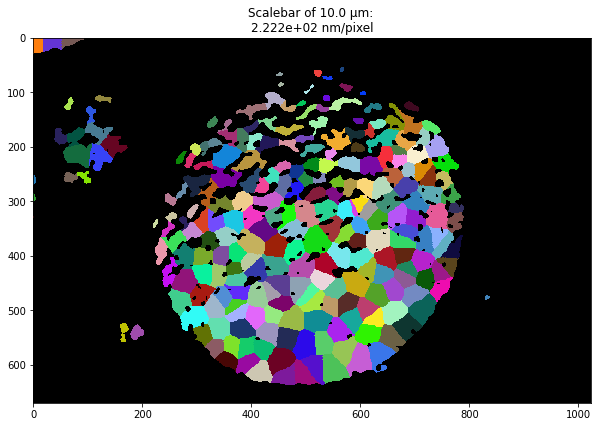

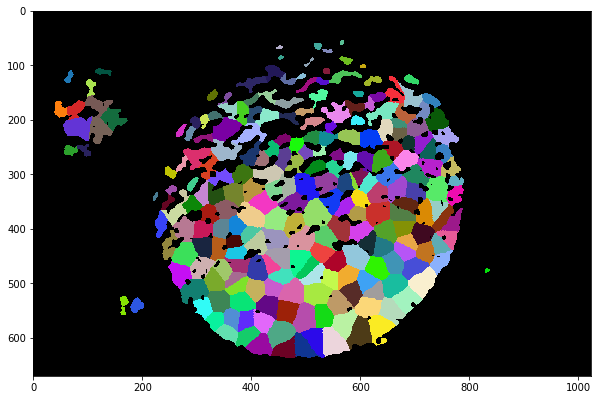

Total objects detected:  240.0


C:\Users\teolo\AppData\Local\Programs\Python\Python310\lib\site-packages\pyclesperanto_prototype\_tier9\_imshow.py:46: UserWarning: The imshow parameter color_map is deprecated. Use colormap instead.
  warnings.warn("The imshow parameter color_map is deprecated. Use colormap instead.")


Paticles identification done
Index(['label', 'original_label', 'bbox_min_x', 'bbox_min_y', 'bbox_min_z',
       'bbox_max_x', 'bbox_max_y', 'bbox_max_z', 'bbox_width', 'bbox_height',
       'bbox_depth', 'min_intensity', 'max_intensity', 'sum_intensity', 'area',
       'mean_intensity', 'sum_intensity_times_x', 'mass_center_x',
       'sum_intensity_times_y', 'mass_center_y', 'sum_intensity_times_z',
       'mass_center_z', 'sum_x', 'centroid_x', 'sum_y', 'centroid_y', 'sum_z',
       'centroid_z', 'sum_distance_to_centroid', 'mean_distance_to_centroid',
       'sum_distance_to_mass_center', 'mean_distance_to_mass_center',
       'standard_deviation_intensity', 'max_distance_to_centroid',
       'max_distance_to_mass_center', 'mean_max_distance_to_centroid_ratio',
       'mean_max_distance_to_mass_center_ratio', 'perimeter'],
      dtype='object')
Paticles properties determination and plotting done done

02_05.tif
Scalebar detectected. Pixel resolution =  111.11111111111111


C:\Users\teolo\AppData\Local\Temp\ipykernel_268\781834158.py:68: FutureWarning: `multichannel` is a deprecated argument name for `denoise_nl_means`. It will be removed in version 1.0. Please use `channel_axis` instead.
  NLM_denoised = denoise_nl_means(original_img, h=0.04, fast_mode=True, patch_size=5, patch_distance=6, multichannel=False, preserve_range=False)


Denoise done
Histogram equalization done


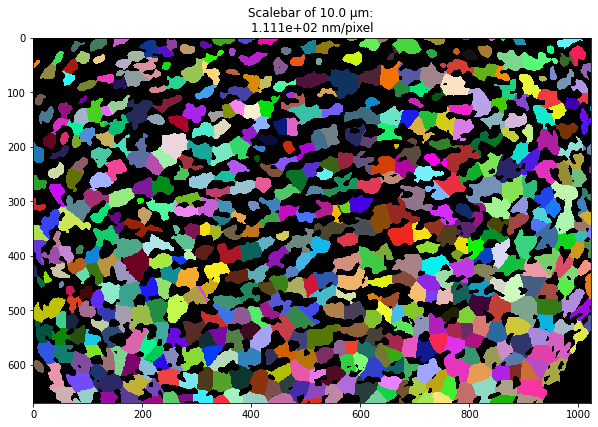

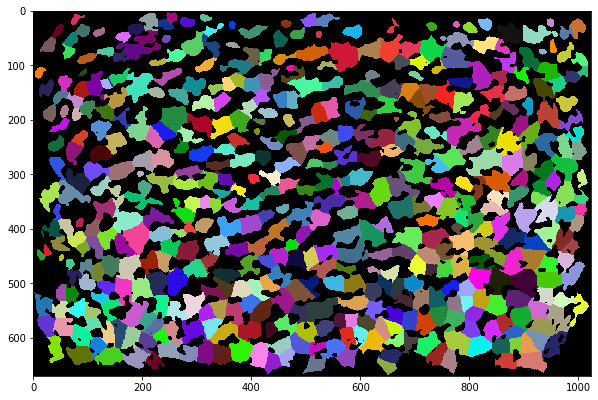

Total objects detected:  500.0


C:\Users\teolo\AppData\Local\Programs\Python\Python310\lib\site-packages\pyclesperanto_prototype\_tier9\_imshow.py:46: UserWarning: The imshow parameter color_map is deprecated. Use colormap instead.
  warnings.warn("The imshow parameter color_map is deprecated. Use colormap instead.")


Paticles identification done
Index(['label', 'original_label', 'bbox_min_x', 'bbox_min_y', 'bbox_min_z',
       'bbox_max_x', 'bbox_max_y', 'bbox_max_z', 'bbox_width', 'bbox_height',
       'bbox_depth', 'min_intensity', 'max_intensity', 'sum_intensity', 'area',
       'mean_intensity', 'sum_intensity_times_x', 'mass_center_x',
       'sum_intensity_times_y', 'mass_center_y', 'sum_intensity_times_z',
       'mass_center_z', 'sum_x', 'centroid_x', 'sum_y', 'centroid_y', 'sum_z',
       'centroid_z', 'sum_distance_to_centroid', 'mean_distance_to_centroid',
       'sum_distance_to_mass_center', 'mean_distance_to_mass_center',
       'standard_deviation_intensity', 'max_distance_to_centroid',
       'max_distance_to_mass_center', 'mean_max_distance_to_centroid_ratio',
       'mean_max_distance_to_mass_center_ratio', 'perimeter'],
      dtype='object')
Paticles properties determination and plotting done done

02_06.tif
Scalebar detectected. Pixel resolution =  222.22222222222223


C:\Users\teolo\AppData\Local\Temp\ipykernel_268\781834158.py:68: FutureWarning: `multichannel` is a deprecated argument name for `denoise_nl_means`. It will be removed in version 1.0. Please use `channel_axis` instead.
  NLM_denoised = denoise_nl_means(original_img, h=0.04, fast_mode=True, patch_size=5, patch_distance=6, multichannel=False, preserve_range=False)


Denoise done
Histogram equalization done


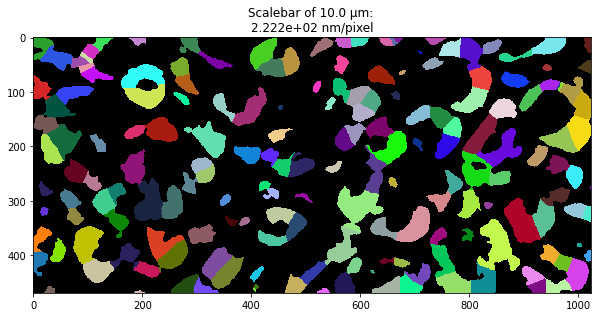

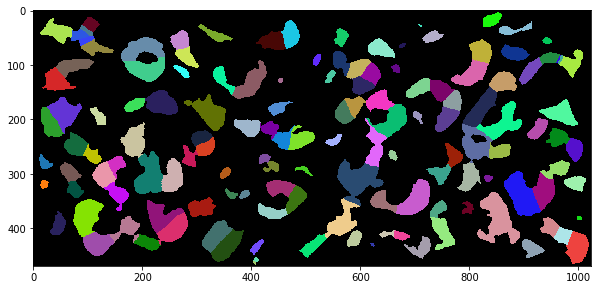

Total objects detected:  138.0


C:\Users\teolo\AppData\Local\Programs\Python\Python310\lib\site-packages\pyclesperanto_prototype\_tier9\_imshow.py:46: UserWarning: The imshow parameter color_map is deprecated. Use colormap instead.
  warnings.warn("The imshow parameter color_map is deprecated. Use colormap instead.")


Paticles identification done
Index(['label', 'original_label', 'bbox_min_x', 'bbox_min_y', 'bbox_min_z',
       'bbox_max_x', 'bbox_max_y', 'bbox_max_z', 'bbox_width', 'bbox_height',
       'bbox_depth', 'min_intensity', 'max_intensity', 'sum_intensity', 'area',
       'mean_intensity', 'sum_intensity_times_x', 'mass_center_x',
       'sum_intensity_times_y', 'mass_center_y', 'sum_intensity_times_z',
       'mass_center_z', 'sum_x', 'centroid_x', 'sum_y', 'centroid_y', 'sum_z',
       'centroid_z', 'sum_distance_to_centroid', 'mean_distance_to_centroid',
       'sum_distance_to_mass_center', 'mean_distance_to_mass_center',
       'standard_deviation_intensity', 'max_distance_to_centroid',
       'max_distance_to_mass_center', 'mean_max_distance_to_centroid_ratio',
       'mean_max_distance_to_mass_center_ratio', 'perimeter'],
      dtype='object')
Paticles properties determination and plotting done done

02_07.tif
Scalebar detectected. Pixel resolution =  111.11111111111111


C:\Users\teolo\AppData\Local\Temp\ipykernel_268\781834158.py:68: FutureWarning: `multichannel` is a deprecated argument name for `denoise_nl_means`. It will be removed in version 1.0. Please use `channel_axis` instead.
  NLM_denoised = denoise_nl_means(original_img, h=0.04, fast_mode=True, patch_size=5, patch_distance=6, multichannel=False, preserve_range=False)


Denoise done
Histogram equalization done


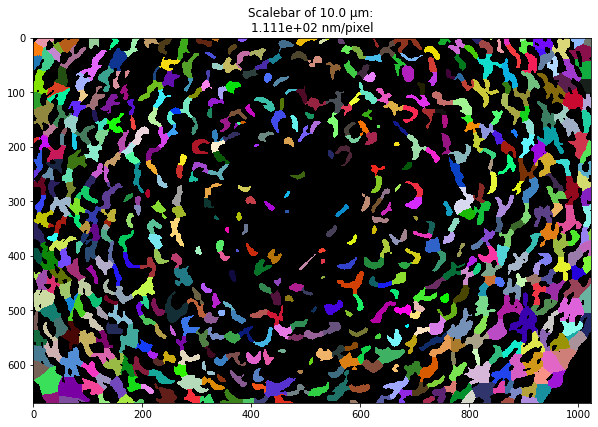

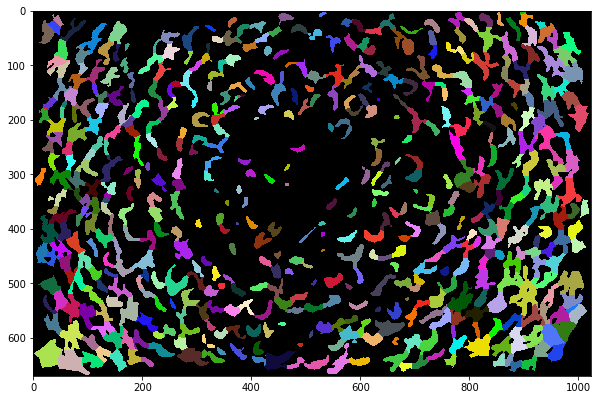

Total objects detected:  532.0


C:\Users\teolo\AppData\Local\Programs\Python\Python310\lib\site-packages\pyclesperanto_prototype\_tier9\_imshow.py:46: UserWarning: The imshow parameter color_map is deprecated. Use colormap instead.
  warnings.warn("The imshow parameter color_map is deprecated. Use colormap instead.")


Paticles identification done
Index(['label', 'original_label', 'bbox_min_x', 'bbox_min_y', 'bbox_min_z',
       'bbox_max_x', 'bbox_max_y', 'bbox_max_z', 'bbox_width', 'bbox_height',
       'bbox_depth', 'min_intensity', 'max_intensity', 'sum_intensity', 'area',
       'mean_intensity', 'sum_intensity_times_x', 'mass_center_x',
       'sum_intensity_times_y', 'mass_center_y', 'sum_intensity_times_z',
       'mass_center_z', 'sum_x', 'centroid_x', 'sum_y', 'centroid_y', 'sum_z',
       'centroid_z', 'sum_distance_to_centroid', 'mean_distance_to_centroid',
       'sum_distance_to_mass_center', 'mean_distance_to_mass_center',
       'standard_deviation_intensity', 'max_distance_to_centroid',
       'max_distance_to_mass_center', 'mean_max_distance_to_centroid_ratio',
       'mean_max_distance_to_mass_center_ratio', 'perimeter'],
      dtype='object')
Paticles properties determination and plotting done done

02_08.tif
Scalebar detectected. Pixel resolution =  111.11111111111111


C:\Users\teolo\AppData\Local\Temp\ipykernel_268\781834158.py:68: FutureWarning: `multichannel` is a deprecated argument name for `denoise_nl_means`. It will be removed in version 1.0. Please use `channel_axis` instead.
  NLM_denoised = denoise_nl_means(original_img, h=0.04, fast_mode=True, patch_size=5, patch_distance=6, multichannel=False, preserve_range=False)


Denoise done
Histogram equalization done


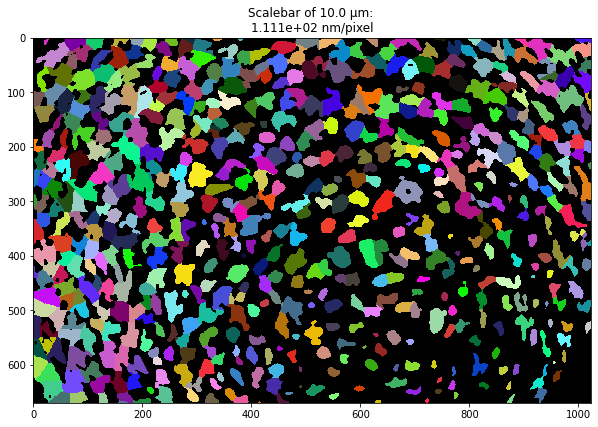

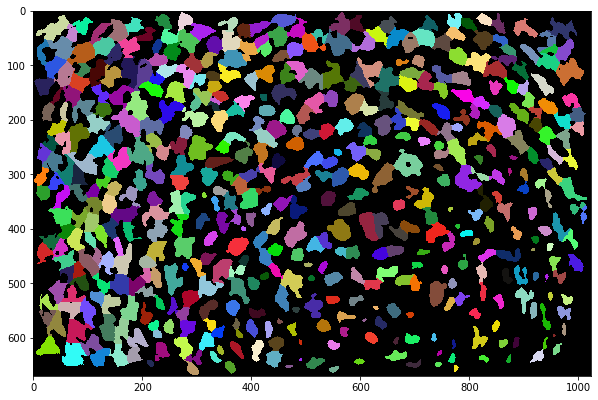

Total objects detected:  504.0


C:\Users\teolo\AppData\Local\Programs\Python\Python310\lib\site-packages\pyclesperanto_prototype\_tier9\_imshow.py:46: UserWarning: The imshow parameter color_map is deprecated. Use colormap instead.
  warnings.warn("The imshow parameter color_map is deprecated. Use colormap instead.")


Paticles identification done
Index(['label', 'original_label', 'bbox_min_x', 'bbox_min_y', 'bbox_min_z',
       'bbox_max_x', 'bbox_max_y', 'bbox_max_z', 'bbox_width', 'bbox_height',
       'bbox_depth', 'min_intensity', 'max_intensity', 'sum_intensity', 'area',
       'mean_intensity', 'sum_intensity_times_x', 'mass_center_x',
       'sum_intensity_times_y', 'mass_center_y', 'sum_intensity_times_z',
       'mass_center_z', 'sum_x', 'centroid_x', 'sum_y', 'centroid_y', 'sum_z',
       'centroid_z', 'sum_distance_to_centroid', 'mean_distance_to_centroid',
       'sum_distance_to_mass_center', 'mean_distance_to_mass_center',
       'standard_deviation_intensity', 'max_distance_to_centroid',
       'max_distance_to_mass_center', 'mean_max_distance_to_centroid_ratio',
       'mean_max_distance_to_mass_center_ratio', 'perimeter'],
      dtype='object')
Paticles properties determination and plotting done done

02_09.tif
Scalebar detectected. Pixel resolution =  185.1851851851852


C:\Users\teolo\AppData\Local\Temp\ipykernel_268\781834158.py:68: FutureWarning: `multichannel` is a deprecated argument name for `denoise_nl_means`. It will be removed in version 1.0. Please use `channel_axis` instead.
  NLM_denoised = denoise_nl_means(original_img, h=0.04, fast_mode=True, patch_size=5, patch_distance=6, multichannel=False, preserve_range=False)


Denoise done
Histogram equalization done


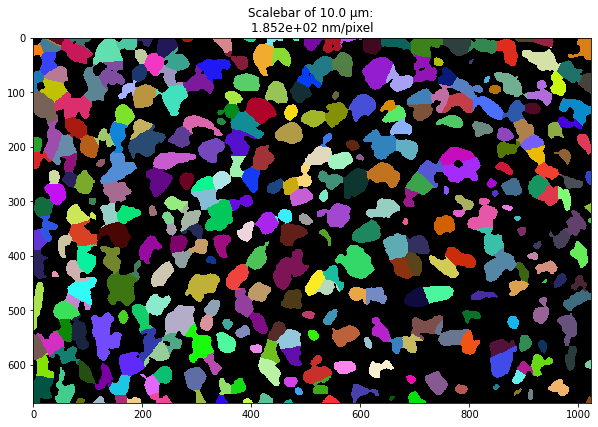

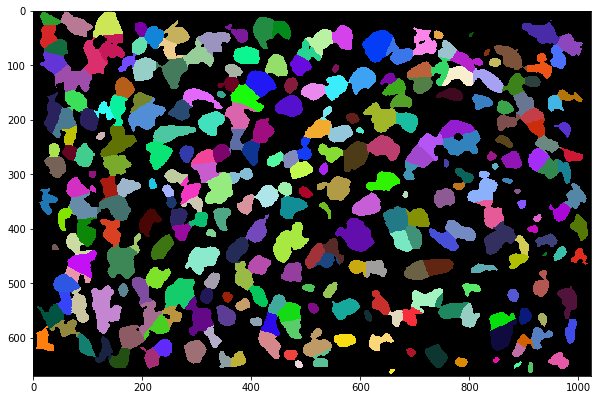

Total objects detected:  290.0


C:\Users\teolo\AppData\Local\Programs\Python\Python310\lib\site-packages\pyclesperanto_prototype\_tier9\_imshow.py:46: UserWarning: The imshow parameter color_map is deprecated. Use colormap instead.
  warnings.warn("The imshow parameter color_map is deprecated. Use colormap instead.")


Paticles identification done
Index(['label', 'original_label', 'bbox_min_x', 'bbox_min_y', 'bbox_min_z',
       'bbox_max_x', 'bbox_max_y', 'bbox_max_z', 'bbox_width', 'bbox_height',
       'bbox_depth', 'min_intensity', 'max_intensity', 'sum_intensity', 'area',
       'mean_intensity', 'sum_intensity_times_x', 'mass_center_x',
       'sum_intensity_times_y', 'mass_center_y', 'sum_intensity_times_z',
       'mass_center_z', 'sum_x', 'centroid_x', 'sum_y', 'centroid_y', 'sum_z',
       'centroid_z', 'sum_distance_to_centroid', 'mean_distance_to_centroid',
       'sum_distance_to_mass_center', 'mean_distance_to_mass_center',
       'standard_deviation_intensity', 'max_distance_to_centroid',
       'max_distance_to_mass_center', 'mean_max_distance_to_centroid_ratio',
       'mean_max_distance_to_mass_center_ratio', 'perimeter'],
      dtype='object')
Paticles properties determination and plotting done done



<Figure size 720x720 with 0 Axes>

In [4]:
# Recover image and create result directories

measurements = os.listdir(folder_name)
results_folder = folder_name + "\\" + "All_Results"
results_folder_each = results_folder + "\\" + "Image-by-image"
results_folder_all = results_folder + "\\" + "All"

try: 
    os.makedirs(results_folder)
except:
    pass

try: 
    os.makedirs(results_folder_each)
except:
    pass

try: 
    os.makedirs(results_folder_all)
except:
    pass

stats_all_dict = {}
#properties_dict = {}
count = 0
for measurement in measurements: 
    path_original = folder_name + "\\" + measurement
    try:
        print(measurement)
        img = img_as_ubyte(imread((path_original), as_gray=True))
        plt.imshow(img, cmap='gray')

        directory_res_0 = results_folder_each + "\\" + measurement 
        directory_res = directory_res_0 + "\\" + "Voronoi segmentation"
        directory_checks = directory_res_0 + "\\" + "Checks"

        try: 
            os.makedirs(directory_res_0)
        except:
            pass

        try: 
            os.makedirs(directory_res)
        except:
            pass

        try: 
            os.makedirs(directory_checks)
        except:
            pass


        # Identify scalebar pixel lenght and calculate resolution
        boundary_h, boundary_v = scalebar_detection(img, color_bkg='w', color_bar='b', fib=False) # color_bkg and color_bar to be indicated as beginner users parameters
        ime = img[boundary_h: , (boundary_v[0]+1):(boundary_v[1]+1)]

        # Calculates the pixel lengh in nm
        pixel_lenght = 1000*scalebar_lenght/(boundary_v[1]-boundary_v[0])

        # Plotting Jargon
        plt.imshow(ime, cmap='gray')
        plt.title('Scalebar of {} µm: \n{:.3e} nm/pixel'.format(scalebar_lenght, pixel_lenght ))
        print("Scalebar detectected. Pixel resolution = ", pixel_lenght)

        # Denoising of the original image
        original_img = img[:boundary_h-1,:]
        #plt.imshow(original_img, cmap="gray")
        NLM_denoised = denoise_nl_means(original_img, h=0.04, fast_mode=True, patch_size=5, patch_distance=6, multichannel=False, preserve_range=False)
        NLM_denoised = img_as_ubyte(NLM_denoised)
        print("Denoise done")

        clip_lim = 1 # Parameter for expert users
        grid_clahe = 8 # Parameter for expert users
        clahe = cv2.createCLAHE(clipLimit=clip_lim, tileGridSize=(grid_clahe,grid_clahe)) # cliplimit and titleGridSize as expert user parameters -1,2 for cliplimit seems good for my case, but typically values seems to be 3,4
        equalised_img = clahe.apply(NLM_denoised)
        #equalised_img = img_as_ubyte(exposure.equalize_adapthist(NLM_denoised, kernel_size = 600, clip_limit=0.007))
        #equalised_img = img_as_ubyte(equalised_img)

        fig = plt.figure(figsize=(18,6))
        ax1 = fig.add_subplot(1,3,1)
        ax1.imshow(original_img, cmap="gray")
        ax1.title.set_text("Original")
        ax1 = fig.add_subplot(1,3,2)
        ax1.imshow(NLM_denoised, cmap="gray")
        ax1.title.set_text("NLM denoised")
        ax1 = fig.add_subplot(1,3,3)
        ax1.imshow(equalised_img, cmap="gray")
        ax1.title.set_text("NLM denoised + CLAHE")
        path_save = directory_checks + "\\" + "Denoise comparison.png"
        plt.savefig(path_save, dpi=600)
        plt.close()

        # Checking histograms
        fig = plt.figure(figsize=(18,6))
        ax1 = fig.add_subplot(1,3,1)
        ax1.hist(original_img.flat, bins=200, range=(0,255))
        ax1.title.set_text("Original")
        ax1 = fig.add_subplot(1,3,2)
        ax1.hist(NLM_denoised.flat, bins=200, range=(0,255))
        ax1.title.set_text("NLM denoised")
        ax1 = fig.add_subplot(1,3,3)
        ax1.hist(equalised_img.flat, bins=200, range=(0,255))
        ax1.title.set_text("NLM denoised + CLAHE")
        path_save = directory_checks + "\\" + "Denoise comparison - histograms.png"
        plt.savefig(path_save, dpi=600)
        plt.close()

        print("Histogram equalization done")

        # Pyclesperanto-based instance (particle) segmentation
        segmented_cle = cle.voronoi_otsu_labeling(equalised_img, spot_sigma=sigma_voronoi_center, outline_sigma=sigma_dividing) #First Gaussian filter sigma (higher) to find the center of the voronois, and second sigma (smaller) for dividing (like watershed) the different instance/object
        # Higher the first sigma less particles/particles splitting find, and vice versa
        #fig = plt.subplots(1, 2, figsize=(9,9))
        cle.imshow(segmented_cle, labels=True)

        #Remove edge touching objects
        if border == True: 
            segmented_excl_edges = cle.exclude_labels_on_edges(segmented_cle)
        if border == False:
            segmented_excl_edges = segmented_cle

        cle.imshow(segmented_excl_edges, labels=True)


        #path_save = directory_res + "\\" + "Recognized particles - Voronoi.png"
        #plt.savefig(path_save, dpi=600)

        # Number of objects segmented?
        #This will be the maximum label assigned to an object 9as each object is assigned unique label value)
        num_objects = cle.maximum_of_all_pixels(segmented_excl_edges)
        print("Total objects detected: ", num_objects)

        label_edges = cle.detect_label_edges(segmented_excl_edges) * segmented_excl_edges
        #segmented_array_cle = cle.pull(segmented_excl_edges)


        fig, axs = plt.subplots(1, 2, figsize=(12,12))

        # left plot
        cle.imshow(equalised_img, color_map="Greys_r", plot=axs[0])

        # right plot
        cle.imshow(equalised_img, alpha=0.5, continue_drawing=True, color_map="Greys_r", plot=axs[1])
        cle.imshow(label_edges, labels=True, alpha=0.75, plot=axs[1])

        path_save = directory_res + "\\" + "Recognized and overlapped particles - Voronoi.png"
        plt.savefig(path_save, dpi=600)
        plt.close()

        print("Paticles identification done")

        # Calculate particles properties (Voronoi-based instance segmentation)
        statistics = cle.statistics_of_labelled_pixels(equalised_img, segmented_excl_edges) 

        # Define perimeter
        particles_perimenters = {}
        for p in range(1,len(statistics["label"])+1):
            particles_perimenters[p] = 0

        for p in range(1,len(statistics["label"])+1):
            for i in np.array(label_edges):
                for j in i:
                    if int(j) == p:
                        particles_perimenters[p]+=1

        particles_perimenter = []
        for p in particles_perimenters:
            particles_perimenter.append(particles_perimenters[p])
        statistics["perimeter"] = np.array(particles_perimenter)

        stats_table = pd.DataFrame(statistics)    

        #print(stats_table.describe())
        print(stats_table.columns)

        stats_table["area um2"] = stats_table['area']*(pixel_lenght/1000)**2
        stats_table["radius um"] = (stats_table['area um2']/math.pi)**(0.5)
        stats_table["effective volume um3"] = (4/3)*math.pi*stats_table["radius um"]**3
        if density_g_cm3 > 0:
            stats_table["mass g"] = (stats_table["effective volume um3"]/1E12)*density_g_cm3
            stats_table["specific area m2g-1"] = (stats_table["area um2"]/1E12)/stats_table["mass g"]
            
        stats_table["radius pixels"] = (stats_table['area']/math.pi)**(0.5)
        stats_table["area_perim"] = 2*stats_table['area']/(statistics["perimeter"]*stats_table["radius pixels"])
        
        if limit_shape > 0:
            stats_table = stats_table[stats_table["area_perim"]>limit_shape]
            print("Limit shape (1) applied")
        if limit_size > 0:
            stats_table = stats_table[stats_table["radius um"]>limit_size]
            print("Limit size (1) applied")
        
        # Kernel density estimate plots
        sns.kdeplot(stats_table['area um2'], shade=True)
        path_save = directory_res + "\\" + "KDE - Particles area distribution.png"
        plt.savefig(path_save, dpi=600)
        plt.close()
        plt.clf()

        sns.kdeplot(stats_table['radius um'], shade=True)
        path_save = directory_res + "\\" + "KDE - Particles effective radius distribution.png"
        plt.savefig(path_save, dpi=600)
        plt.close()
        plt.clf()

        if density_g_cm3 > 0:
            sns.kdeplot(stats_table["specific area m2g-1"], shade=True)
            path_save = directory_res + "\\" + "KDE - Particles specific area distribution.png"
            plt.savefig(path_save, dpi=600)
            plt.close()
            plt.clf()

        # Histograms plots
        plt.hist(stats_table['area um2'], bins=20)
        plt.xticks(fontsize=22)
        plt.yticks(fontsize=22)
        plt.xlabel("Particles' area (um$^{2}$)", fontsize=28)
        plt.ylabel("Counts", fontsize=28)
        path_save = directory_res + "\\" + "Histograms - Particles area distribution.png"
        plt.savefig(path_save, dpi=600)
        plt.close()
        plt.clf()

        plt.hist(stats_table['radius um'], bins=20)
        plt.xticks(fontsize=22)
        plt.yticks(fontsize=22)
        plt.xlabel("Particles' effective radium (um)", fontsize=28)
        plt.ylabel("Counts", fontsize=28)
        path_save = directory_res + "\\" + "Histograms - Particles effective radius distribution.png"
        plt.savefig(path_save, dpi=600)
        plt.close()
        plt.clf()

        if density_g_cm3 > 0:
            plt.hist(stats_table["specific area m2g-1"], bins=20)
            plt.xticks(fontsize=22)
            plt.yticks(fontsize=22)
            plt.xlabel("Particles' specific area (m$^{2}$ g$^{-1}$))", fontsize=28)
            plt.ylabel("Counts", fontsize=28)
            path_save = directory_res + "\\" + "Histograms - Particles specific area distribution.png"
            plt.savefig(path_save, dpi=600)
            plt.close()
            plt.clf()

        path_save = directory_res + "\\Voronoi - particles properties.csv" 
        stats_table.to_csv(path_save, index=False)
        
        stats_all_dict[measurement] = stats_table

        # Calculate further particles properties

        directory_res_reg_props = directory_res_0 + "\\" + "Region props based"

        try: 
            os.makedirs(directory_res_reg_props)
        except:
            pass

        markers = np.array(segmented_cle)
        #properties_particles = objects_properties(markers, equalised_img)

        props = measure.regionprops_table(markers,equalised_img,
                                              properties=["label",
                                              "area", "equivalent_diameter_area",
                                              "perimeter", "centroid", "solidity", "orientation",
                                               "axis_minor_length", "axis_major_length"])
        properties = pd.DataFrame(props)
        
        properties["Percentage area"] = properties["area"]/sum(properties["area"])
        properties["area_perim"] = 2*properties["area"]/(properties["perimeter"]*(0.5*properties["equivalent_diameter_area"])) # This should be equal to 1 in a perfect circle
        properties["circulary_Wadell"] = (properties["equivalent_diameter_area"]*np.pi) / properties["perimeter"]
        # file:///C:/Users/teolo/Downloads/minerals-09-00768.pdf - 
        #Wadell, H.A. Sphericity and roundness of rock particles. J. Geol. 1933, 41, 310–331. - 
        #Wadell, H.A. Volume, shape and roundness of rock particles. J. Geol. 1932, 40, 443–451.
        properties["aspect ratio"] = properties["axis_major_length"]/properties["axis_minor_length"]
        properties["equivalent_diameter_um"] = properties["equivalent_diameter_area"]*pixel_lenght/1000

        #properties = properties.iloc[1: , :]
        
        if limit_shape > 0:
            properties = properties[properties["area_perim"]>limit_shape]
            print("Limit shape (2) applied")
        if limit_size > 0:
            properties = properties[properties["equivalent_diameter_um"]>limit_size*2]
            print("Limit size (2) applied")

        path_save = directory_res_reg_props + "\\" + "Region Props - particles_properties.csv"

        properties.to_csv(path_save, index=False)
        
        colous = properties["equivalent_diameter_um"]**2/max(properties["equivalent_diameter_um"]**2)
        size = colous*250

        col_hist = "royalblue"
        col_p = plt.cm.cool(colous)

        fig_, ax_ = plt.subplots(ncols=2, nrows=1, figsize=(14, 6))
        sns.histplot(properties["aspect ratio"], bins=20, ax=ax_[0], color=col_hist)
        ax_[0].set_xlabel("Aspect ratio", fontsize=16)
        ax_[0].set_ylabel("Counts", fontsize=16)
        ax_[1].scatter(properties["equivalent_diameter_um"], properties["aspect ratio"], s=size, c=col_p)
        ax_[1].set_xlabel("Equivalent diameter (µm)", fontsize=16)
        ax_[1].set_ylabel("Aspect ratio", fontsize=16)

        path_save = directory_res_reg_props + "\\" + "Aspect ratio.png"

        plt.savefig(path_save, dpi=600)
        plt.close()

        fig_, ax_ = plt.subplots(ncols=2, nrows=2, figsize=(16, 12))

        sns.histplot(properties["circulary_Wadell"], bins=20, ax=ax_[1,0], color=col_hist, binrange=(0,1))
        ax_[1,0].set_xlabel("Wadell circularity", fontsize=16)
        ax_[1,0].set_ylabel("Counts", fontsize=16)
        #ax_[1,0].set_xlim([0,1])
        ax_[1,1].scatter(properties["equivalent_diameter_um"], properties["circulary_Wadell"], s=size, c=col_p)
        ax_[1,1].set_ylim([0,1.05])
        ax_[1,1].set_xlabel("Equivalent diameter (µm)", fontsize=16)
        ax_[1,1].set_ylabel("Wadell circularity", fontsize=16)
        ax_[1,1] = fig.add_subplot(2,2,2)

        sns.histplot(properties["solidity"], bins=20, ax=ax_[0,0], color=col_hist)
        ax_[0,0].set_xlabel("Solidity", fontsize=16)
        ax_[0,0].set_ylabel("Counts", fontsize=16)
        ax_[0,1].scatter(properties["equivalent_diameter_um"], properties["solidity"], s=size, c=col_p)
        ax_[0,1].set_ylim([0,1.05])
        ax_[0,1].set_xlabel("Equivalent diameter (µm)", fontsize=16)
        ax_[0,1].set_ylabel("Solidity", fontsize=16)
        ax_[0,1] = fig.add_subplot(2,2,4)

        path_save = directory_res_reg_props + "\\" + "Particles sphericity and regularity.png"

        plt.savefig(path_save, dpi=600)
        plt.close()
        
        #properties_dict[measurement] = properties

        print("Paticles properties determination and plotting done done")

        if count == 0:
            stats_table_all = stats_table
            properties_all = properties
        if count > 1:
            stats_table_all = pd.concat([stats_table_all, stats_table], ignore_index=True)
            properties_all = pd.concat([properties_all, properties], ignore_index=True)
        print("")
        count+=1
    except:
        continue

In [5]:
# Combined data

directory_res_all = results_folder_all + "\\" + "Voronoi segmentation"
directory_res_reg_props_all = results_folder_all + "\\" + "Region props based"

try: 
    os.makedirs(directory_res_all)
except:
    pass
try: 
    os.makedirs(directory_res_reg_props_all)
except:
    pass

# Kernel density estimate plots
sns.kdeplot(stats_table_all['area um2'], shade=True)
path_save = directory_res_all + "\\" + "KDE - Particles area distribution.png"
plt.savefig(path_save, dpi=600)
plt.clf()
plt.close()

sns.kdeplot(stats_table_all['radius um'], shade=True)
path_save = directory_res_all + "\\" + "KDE - Particles effective radius distribution.png"
plt.savefig(path_save, dpi=600)
plt.clf()
plt.close()

if density_g_cm3 > 0:
    sns.kdeplot(stats_table_all["specific area m2g-1"], shade=True)
    path_save = directory_res_all + "\\" + "KDE - Particles specific area distribution.png"
    plt.savefig(path_save, dpi=600)
    plt.clf()
    plt.close()

# Histograms plots
plt.hist(stats_table_all['area um2'], bins=20)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel("Particles' area (um$^{2}$)", fontsize=28)
plt.ylabel("Counts", fontsize=28)
path_save = directory_res_all + "\\" + "Histograms - Particles area distribution.png"
plt.savefig(path_save, dpi=600)
plt.clf()
plt.close()

plt.hist(stats_table_all['radius um'], bins=20)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel("Particles' effective radium (um)", fontsize=28)
plt.ylabel("Counts", fontsize=28)
path_save = directory_res_all + "\\" + "Histograms - Particles effective radius distribution.png"
plt.savefig(path_save, dpi=600)
plt.clf()
plt.close()

if density_g_cm3 > 0:
    plt.hist(stats_table_all["specific area m2g-1"], bins=20)
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.xlabel("Particles' specific area (m$^{2}$ g$^{-1}$))", fontsize=28)
    plt.ylabel("Counts", fontsize=28)
    path_save = directory_res_all + "\\" + "Histograms - Particles specific area distribution.png"
    plt.savefig(path_save, dpi=600)
    plt.clf()
    plt.close()

path_save = directory_res_all + "\\Voronoi - particles properties.csv" 
stats_table_all.to_csv(path_save, index=False)

# Calculate further particles properties

path_save = directory_res_reg_props_all + "\\" + "Region Props - particles_properties.csv"

properties_all.to_csv(path_save, index=False)

colous = properties_all["equivalent_diameter_um"]**2/max(properties_all["equivalent_diameter_um"]**2)
size = colous*250

col_hist = "royalblue"
col_p = plt.cm.cool(colous)

fig_, ax_ = plt.subplots(ncols=2, nrows=1, figsize=(14, 6))
sns.histplot(properties_all["aspect ratio"], bins=20, ax=ax_[0], color=col_hist)
ax_[0].set_xlabel("Aspect ratio", fontsize=16)
ax_[0].set_ylabel("Counts", fontsize=16)
ax_[1].scatter(properties_all["equivalent_diameter_um"], properties_all["aspect ratio"], s=size, c=col_p)
ax_[1].set_xlabel("Equivalent diameter (µm)", fontsize=16)
ax_[1].set_ylabel("Aspect ratio", fontsize=16)

path_save = directory_res_reg_props_all + "\\" + "Aspect ratio.png"

plt.savefig(path_save, dpi=600)
plt.clf()
plt.close()

fig_, ax_ = plt.subplots(ncols=2, nrows=2, figsize=(16, 12))

sns.histplot(properties_all["circulary_Wadell"], bins=20, ax=ax_[1,0], color=col_hist, binrange=(0,1))
ax_[1,0].set_xlabel("Wadell circularity", fontsize=16)
ax_[1,0].set_ylabel("Counts", fontsize=16)
#ax_[1,0].set_xlim([0,1])
ax_[1,1].scatter(properties_all["equivalent_diameter_um"], properties_all["circulary_Wadell"], s=size, c=col_p)
ax_[1,1].set_ylim([0,1.05])
ax_[1,1].set_xlabel("Equivalent diameter (µm)", fontsize=16)
ax_[1,1].set_ylabel("Wadell circularity", fontsize=16)
ax_[1,1] = fig.add_subplot(2,2,2)

sns.histplot(properties_all["solidity"], bins=20, ax=ax_[0,0], color=col_hist)
ax_[0,0].set_xlabel("Solidity", fontsize=16)
ax_[0,0].set_ylabel("Counts", fontsize=16)
ax_[0,1].scatter(properties_all["equivalent_diameter_um"], properties_all["solidity"], s=size, c=col_p)
ax_[0,1].set_ylim([0,1.05])
ax_[0,1].set_xlabel("Equivalent diameter (µm)", fontsize=16)
ax_[0,1].set_ylabel("Solidity", fontsize=16)
ax_[0,1] = fig.add_subplot(2,2,4)

path_save = directory_res_reg_props_all + "\\" + "Particles sphericity and regularity.png"

plt.savefig(path_save, dpi=600)
plt.clf()
plt.close()

# Kernel density estimate plots of each image overlapped
for m in stats_all_dict:
    sns.kdeplot(stats_all_dict[m]['area um2'], shade=True)
path_save = directory_res_all + "\\" + "KDE - Overlapped particles area distribution.png"
plt.savefig(path_save, dpi=600)
plt.clf()
plt.close()

for m in stats_all_dict:
    sns.kdeplot(stats_all_dict[m]['radius um'], shade=True)
path_save = directory_res_all + "\\" + "KDE - Overlapped particles effective radius distribution.png"
plt.savefig(path_save, dpi=600)
plt.clf()
plt.close()

if density_g_cm3 > 0:
    for m in stats_all_dict:
        sns.kdeplot(stats_all_dict[m]["specific area m2g-1"], shade=True)
    path_save = directory_res_all + "\\" + "KDE - Overlapped particles specific area distribution.png"
    plt.savefig(path_save, dpi=600)
    plt.clf()
    plt.close()
    
# Kernel density estimate plots of each image overlapped (with legends)
for m in stats_all_dict:
    sns.kdeplot(stats_all_dict[m]['area um2'], shade=True, label=m)
plt.legend()
path_save = directory_res_all + "\\" + "KDE - Overlapped particles area distribution legend.png"
plt.savefig(path_save, dpi=600)
plt.clf()
plt.close()

for m in stats_all_dict:
    sns.kdeplot(stats_all_dict[m]['radius um'], shade=True, label=m)
plt.legend()
path_save = directory_res_all + "\\" + "KDE - Overlapped particles effective radius distribution legend.png"
plt.savefig(path_save, dpi=600)
plt.clf()
plt.close()

if density_g_cm3 > 0:
    for m in stats_all_dict:
        sns.kdeplot(stats_all_dict[m]["specific area m2g-1"], shade=True, label=m)
    plt.legend()
    path_save = directory_res_all + "\\" + "KDE - Overlapped particles specific area distribution legend.png"
    plt.savefig(path_save, dpi=600)
    plt.clf()
    plt.close()

C:\Users\teolo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
C:\Users\teolo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
C:\Users\teolo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
C:\Users\teolo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, U